# Customer Churn Prediction and Retention Strategy
![](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exploratory Data Analysis
> First we do data exploration to get the sense of data and check for any inconsistency, outliers, and unexpected distribution.

### Import Necessary Libraries

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
import missingno as msno
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

# modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# splitting data and model evaluation
from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# sampling
from imblearn.under_sampling import NearMiss
from collections import Counter

# cross-validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

### Import Dataset

In [2]:
df =pd.read_csv('Data/Customer-Churn-Records.csv')
# print shape of data
print('Number of instances : ', df.shape[0])
print('Number of features : ', df.shape[1])
df.head()

Number of instances :  10000
Number of features :  18


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Droping Not So Necessary Columns
The following columns were removed from the raw dataset before analysis and modeling:
>RowNumber(not an actual customer attribute), Surname(Usually don't directly drive churn)

In [3]:
df.drop(['RowNumber', 'Surname'], axis=1, inplace=True)
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Check Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerId          10000 non-null  int64  
 1   CreditScore         10000 non-null  int64  
 2   Geography           10000 non-null  object 
 3   Gender              10000 non-null  object 
 4   Age                 10000 non-null  int64  
 5   Tenure              10000 non-null  int64  
 6   Balance             10000 non-null  float64
 7   NumOfProducts       10000 non-null  int64  
 8   HasCrCard           10000 non-null  int64  
 9   IsActiveMember      10000 non-null  int64  
 10  EstimatedSalary     10000 non-null  float64
 11  Exited              10000 non-null  int64  
 12  Complain            10000 non-null  int64  
 13  Satisfaction Score  10000 non-null  int64  
 14  Card Type           10000 non-null  object 
 15  Point Earned        10000 non-null  int64  
dtypes: fl

### Initialize Category & Numeric Data

In [5]:
# initialize category and numeric data
category = [i for i in df.columns if df[i].dtype == 'object']
numerical = [i for i in df.columns if df[i].dtype != 'object']

### Check Statistical Summary Of Data Set

In [6]:
# show statistical summary of numeric data
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
Exited,10000.0,2.038000e-01,0.402842,0.00,0.00,0.000000e+00,0.000000e+00,1.00


### Check Statistical Summary of Category Data

In [7]:
# show statistical summary of category data
df[category].describe().T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
Card Type,10000,4,DIAMOND,2507


![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*gpA1Jog4xyG_DHgwpZXHvQ.png)
# Data Preparation
## Data Preprocessing
> Check and handle for missing and duplicate values. Then do required data transformations.

In [8]:
# show duplicated data
df.duplicated().sum()

0

In [10]:
# show missing values of data
df.isnull().sum()

CustomerId            0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

## Feature Engineering
#### Required Data Transformation

In [12]:
# create a new column 'Age Group' based on the 'Age' column
df['Age Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, np.inf], labels=['<30', '30-40', '40-50', '50-60', '60+'])

df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Age Group
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,40-50
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,40-50
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,40-50
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,30-40
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,40-50


### Categorical Data Encoding

In [13]:
# identify categorical columns in the DataFrame
category = [i for i in df.columns if df[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(df[col].value_counts())
    print()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

Card Type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64



In [14]:
# show category columns
df[category].columns

Index(['Geography', 'Gender', 'Card Type'], dtype='object')

## Implementing One-Hot Encoding, Ordinal Encoding, and Frequency Encoding

In [23]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce

# define a function to encode category data into numeric
def encode_data(data, columns, method):
    
    # one-hot encoding
    if method == 'ohe':
        encoded_columns = pd.get_dummies(data[columns], prefix=columns)
        data = pd.concat([data, encoded_columns], axis=1)
        data.drop(columns, axis=1, inplace=True)   
        
    # ordinal encoding
    elif method == 'ordinal':
        ordinal_enc = OrdinalEncoder()
        encoded_columns = ordinal_enc.fit_transform(data[columns])
        data[columns] = encoded_columns
        data[columns] = encoded_columns.astype(int)
      
    # frequency encoding
    elif method == 'frequency':
        encoder = ce.CountEncoder(cols=columns)
        data = encoder.fit_transform(data)
        
        # for column in columns:
        #     frequency_encoding = data[column].value_counts(normalize=True).to_dict()
        #     data[column] = data[column].replace(frequency_encoding)
    
    return data

In [24]:
ordinal_columns = ['Geography', 'Gender', 'Card Type', 'Age Group']

train = df.copy()

# apply the 'encode_data' function to 'ordinal_columns'
train = encode_data(train, ordinal_columns, method='ordinal')

train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Age Group
0,15634602,619,0,0,42,2,0.00,1,1,1,101348.88,1,1,2,0,464,1
1,15647311,608,2,0,41,1,83807.86,1,0,1,112542.58,0,1,3,0,456,1
2,15619304,502,0,0,42,8,159660.80,3,1,0,113931.57,1,1,3,0,377,1
3,15701354,699,0,0,39,1,0.00,2,0,0,93826.63,0,0,5,1,350,0
4,15737888,850,2,0,43,2,125510.82,1,1,1,79084.10,0,0,5,1,425,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,0,1,39,5,0.00,2,1,0,96270.64,0,0,1,0,300,0
9996,15569892,516,0,1,35,10,57369.61,1,1,1,101699.77,0,0,5,2,771,0
9997,15584532,709,0,0,36,7,0.00,1,0,1,42085.58,1,1,3,3,564,0
9998,15682355,772,1,1,42,3,75075.31,2,1,0,92888.52,1,1,2,1,339,1


In [25]:
# show shape of df
df.shape

(10000, 17)

In [26]:
# show shape of train
train.shape

(10000, 17)

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*IrP8hlu_kWhN0us0t2F62Q.png)
# Exploratory Data Analysis
**Objective:**
>Identify patterns and correlations associated with churn to inform feature engineering and modeling strategies.
>Highlight customer segments with heightened churn risk for targeted retention efforts.

## Univariate Analysis


In [ ]:
"""
Parameters:
    data (DataFrame): The input data.
    column (str): The variable to be plotted on the x-axis (or y-axis, based on the `orient` parameter).
    hue (str): The third variable to differentiate categories (optional).
    label (str): The label for the variable on the x-axis (or y-axis).
    max_sample (int): The maximum number of categories to be shown on the plot.
    num_x_ticks (int): The number of x-axis ticks to be customized.
    x_ticks (list): The list of x-axis tick labels to be customized.
    width (float): The width of the plot.
    height (float): The height of the plot.
    y_title (float): The distance between the title and the plot.
    orient (str): The orientation of the plot ('vertical' or 'horizontal').
    title (str): The title of the plot.
""" plot.
"""

In [27]:
# define a procedure to plot countplot for univariate analysis
def countplot_univariate(data, column, hue, label, max_sample, num_x_ticks, x_ticks, width, height, y_title, orient, title):
    
    # create a new figure with the specified width, height and title
    plt.figure(figsize=(width, height))
    plt.suptitle(f'{title}', y=y_title)

    # determine the order of the categories based on the maximum sample size
    order = data[column].value_counts().nlargest(max_sample).index if max_sample > 0 else data[column].value_counts().index

    # create a countplot based on the specified orientation
    if orient == 'vertical':
        g = sns.countplot(x=column, hue=hue, order=order, data=data, palette='muted')
        g.set(xlabel=label, ylabel='Number')
    elif orient == 'horizontal':
        g = sns.countplot(y=column, hue=hue, order=order, data=data, palette='muted')
        g.set(xlabel='Number', ylabel=label)

    plt.legend(title='Exited', labels=['Retain', 'Churn'], fontsize=11)

    # customize the x-axis ticks if the number of ticks is specified
    if num_x_ticks > 0:
        x_ticks_list = list(range(num_x_ticks))
        plt.xticks(x_ticks_list, x_ticks, fontsize=11)

    # calculate the total number of observations
    total = len(data[column])

    # add percentage annotations to the bars
    for p in g.patches:
        if orient == 'vertical':
            height = p.get_height()
            percentage = (height / total) * 100
            g.annotate(f'{percentage:.1f}%', (p.get_x() + (p.get_width() + 0.05) / 2, height + 50), \
                            ha='center', va='bottom', fontsize=12)
        elif orient == 'horizontal':
            width = p.get_width()
            percentage = (width / total) * 100
            g.annotate(f'{percentage:.1f}%', (width + 25, p.get_y() + p.get_height() / 2), \
                       ha='left', va='center', fontsize=11)
            
    plt.show()

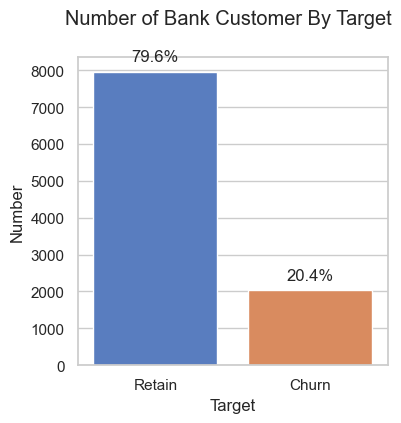

In [28]:
sns.set_theme(style="whitegrid")

chart = 'Number of Bank Customer By Target'

plt.figure(figsize=(4, 4))
plt.suptitle(f'{chart}', y=1)

# plotting countplot based on the target variable
g = sns.countplot(x='Exited', data=df, palette='muted')
g.set(ylabel='Number', xlabel='Target')

# # customize xticks
plt.xticks([0, 1], ['Retain', 'Churn'], fontsize=11)

# annotate the percentage on the chart
total = len(df['Exited'])
for p in g.patches:
            height = p.get_height()
            percentage = (height / total) * 100
            g.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height + 200), \
                            ha='center', va='bottom', fontsize=12)

plt.show()

### **Churn Distribution:**
> The dataset exhibits a class imbalance, with 20.4% of customers labeled as 'Churned'. Strategies to address this imbalance during modeling will be essential.

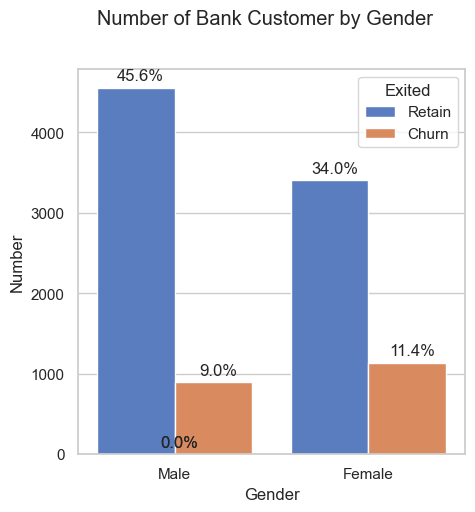

In [29]:
# initialize chart title
chart = 'Number of Bank Customer by Gender'

# apply the procedure to plot the chart
countplot_univariate(df, 'Gender', 'Exited', 'Gender', 0, 0, None, 5, 5, 1, \
                     'vertical', chart)

### Gender and Churn:
> Female customers demonstrate a higher churn rate (11.4%) compared to male customers (9%).

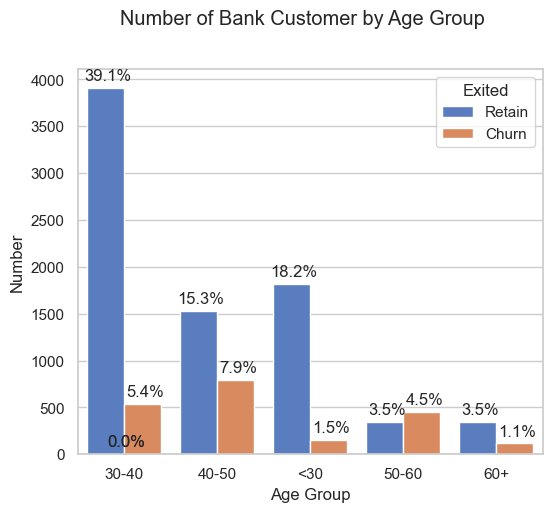

In [30]:
# initialize chart title
chart = 'Number of Bank Customer by Age Group'

# apply the procedure to plot the chart
countplot_univariate(df, 'Age Group', 'Exited', 'Age Group', 0, 0, None, 6, 5, 1, \
                     'vertical', chart)

### Age and Churn: 
> Customers in the 40–50 age group exhibit the highest churn rate (7.9%), followed by those aged 30–40 (5.4%). Churn rates are lowest in the under-30 and over-60 groups.

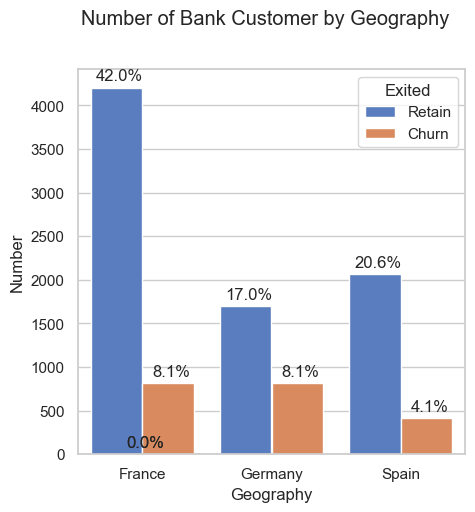

In [31]:
# initialize chart title
chart = 'Number of Bank Customer by Geography'

# apply the procedure to plot the chart
countplot_univariate(df, 'Geography', 'Exited', 'Geography', 0, 0, None, 5, 5, 1, \
                     'vertical', chart)

### Geography and Churn:
> France and Germany exhibit similar churn rates (8.1%), exceeding that of Spain (4.1%).

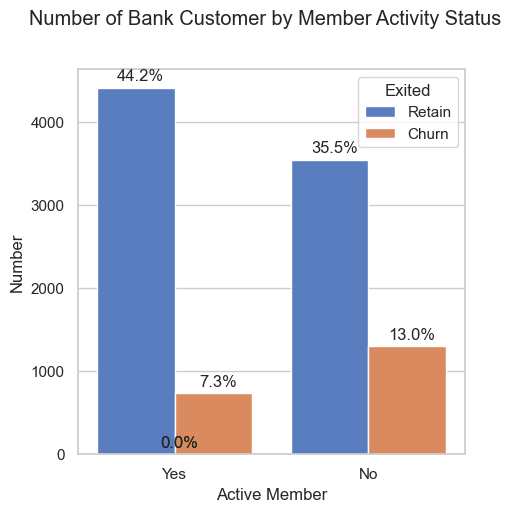

In [32]:
# initialize chart title
chart = 'Number of Bank Customer by Member Activity Status'

# apply the procedure to plot the chart
countplot_univariate(df, 'IsActiveMember', 'Exited', 'Active Member', 0, 2, ['Yes', 'No'], 5, 5, 1, \
                     'vertical', chart)

### Membership Activity and Churn:
>Inactive members demonstrate a significantly higher churn rate (13%) compared to active members.

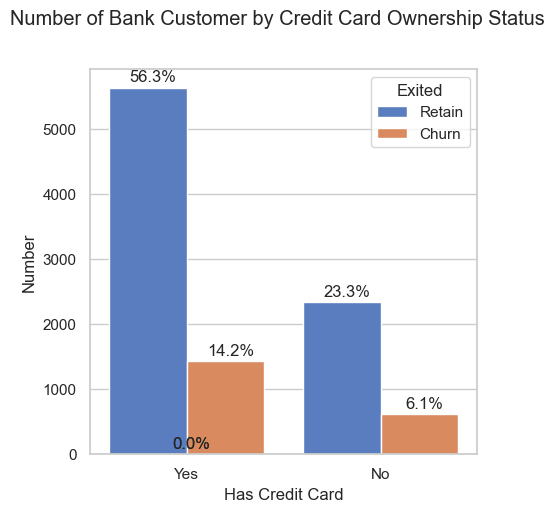

In [33]:
# initialize chart title
chart = 'Number of Bank Customer by Credit Card Ownership Status'

# apply the procedure to plot the chart
countplot_univariate(df, 'HasCrCard', 'Exited', 'Has Credit Card', 0, 2, ['Yes', 'No'], 5, 5, 1, \
                     'vertical', chart)

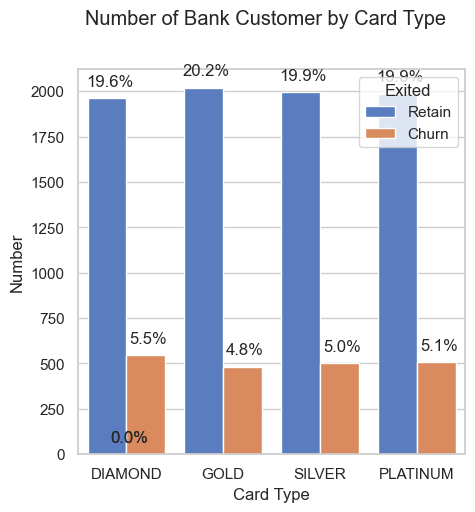

In [34]:
# initialize chart title
chart = 'Number of Bank Customer by Card Type'

# apply the procedure to plot the chart
countplot_univariate(df, 'Card Type', 'Exited', 'Card Type', 0, 0, None, 5, 5, 1, \
                     'vertical', chart)

### Credit Card Ownership and Churn: 
>Customers with credit cards churn at a higher rate (14.2%) than those without (6.1%).

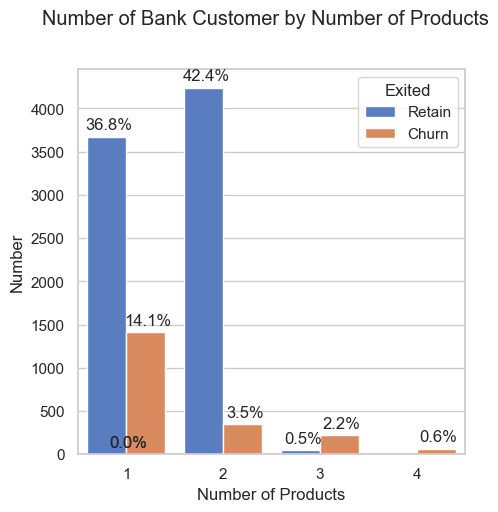

In [35]:
# initialize chart title
chart = 'Number of Bank Customer by Number of Products'

# apply the procedure to plot the chart
countplot_univariate(df, 'NumOfProducts', 'Exited', 'Number of Products', 0, 0, None, 5, 5, 1, \
                     'vertical', chart)

### Product Usage and Churn: 
>Customers with at least one product have a higher churn rate (14.1%) compared to those with zero products.

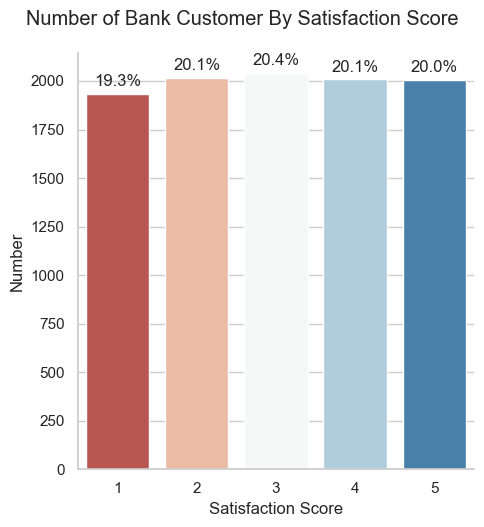

In [36]:
chart = 'Number of Bank Customer By Satisfaction Score'

g = sns.catplot(x='Satisfaction Score', data=df, kind='count', height=5, palette='RdBu')
g.set(ylabel='Number', xlabel='Satisfaction Score')
g.fig.suptitle(f'{chart}', y=1.05)
            
total = len(df)
for p in g.ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    g.ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height + 25),
                  ha='center', va='bottom', fontsize=12)
            
plt.show()

### Satisfaction Score Distribution:
>Satisfaction scores are relatively evenly distributed across their range (19–20% representation for each score).

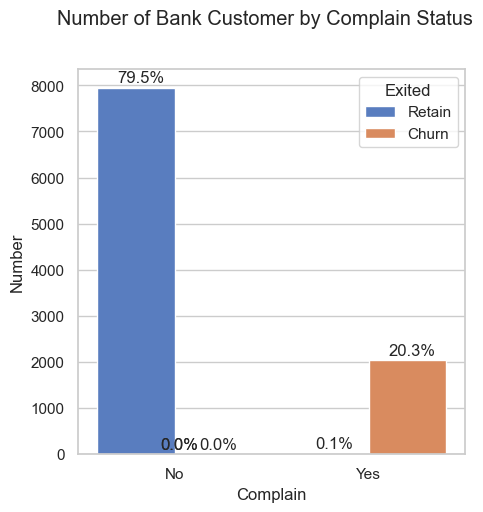

In [38]:
# initialize chart title
chart = 'Number of Bank Customer by Complain Status'

# apply the procedure to plot the chart
countplot_univariate(df, 'Complain', 'Exited', 'Complain', 0, 2, ['No', 'Yes'], 5, 5, 1, \
                     'vertical', chart)

### Complaints and Churn:
>Customers marked as 'Churned' all have a history of complaints. This correlation warrants further investigation.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6dl7rfPwvj1_6Kqq7kIVWA.png)
# Bivariate Analysis

In [39]:
sns.set_theme(style="white")

df2 = df.copy()
df2['Churn Status'] = df2['Exited'].map({1: 'Churn', 0: 'Retain'})

In [40]:
# define a procedure to plot boxplot and histplot for bivariate analysis
def distribution_bivariate(data, x, y, hue, width, height, label):
    
    # create a new figure with the specified width and height
    fig, axes = plt.subplots(1, 2, figsize=(width, height))

    # create a boxplot based on the specified parameter
    sns.boxplot(ax=axes[0], y=y, x=x, showmeans=True, palette='muted', data=data)
    axes[0].set_title(f'Boxplot of {label} by Churn Status', y=1.05)

    # create a histplot based on the specified parameter
    sns.histplot(ax=axes[1], data=data, x=y, hue=hue, kde=True, palette='muted')
    axes[1].set_title(f'Histogram of {label} by Churn Status', y=1.05)

    plt.tight_layout()
    plt.show()

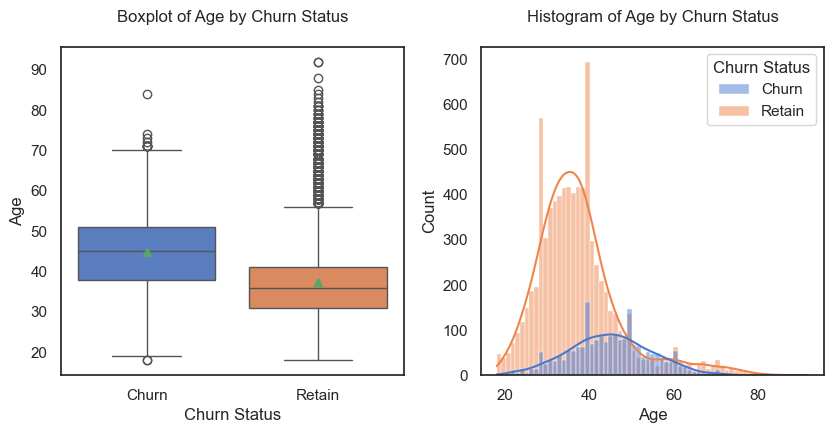

In [41]:
# apply the procedure to plot the chart
distribution_bivariate(df2, 'Churn Status', 'Age', 'Churn Status', 8.5, 4.5, 'Age')

## Age:
>Age distributions for churned and retained customers are broadly similar, with a concentration between 30–50 years old.
>The above graph shows the distribution of 'Age' based on churn status. The age distribution of churned and retained bank customers is relatively similar, spread between the ages of 30 years to 50 years. The age distribution of retained bank customers is mostly between the ages of 30 years and 40 years.

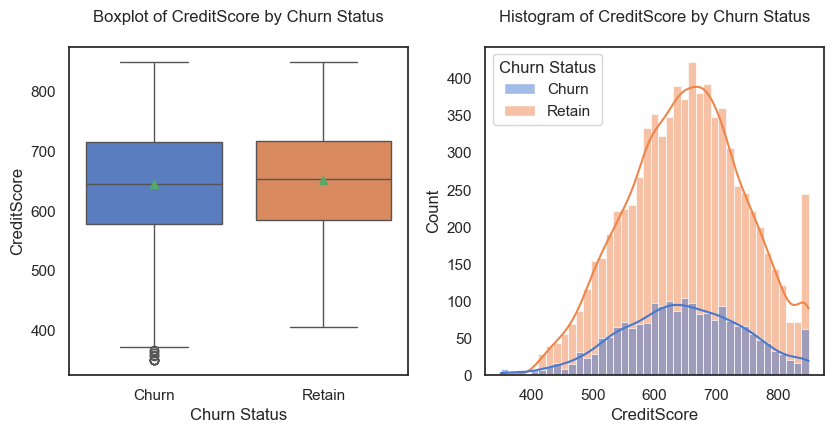

In [42]:
# apply the procedure to plot the chart
distribution_bivariate(df2, 'Churn Status', 'CreditScore', 'Churn Status', 8.5, 4.5, 'CreditScore')

# Credit Score:
> Credit score distributions are comparable for both churned and retained segments, with a peak around 600–700.

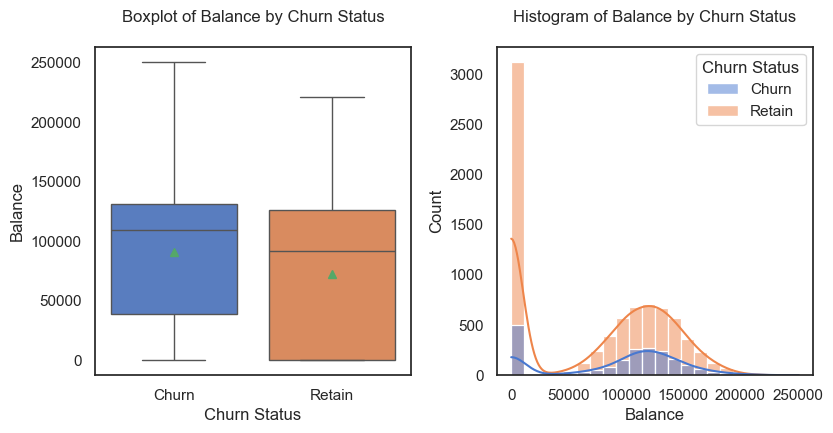

In [43]:
# apply the procedure to plot the chart
distribution_bivariate(df2, 'Churn Status', 'Balance', 'Churn Status', 8.5, 4.5, 'Balance')

# Balance: 
> Balance distribution for churned customers skews lower (more concentration between 40,000–125,000) than retained customers.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6dl7rfPwvj1_6Kqq7kIVWA.png)
# Correlation Analysis

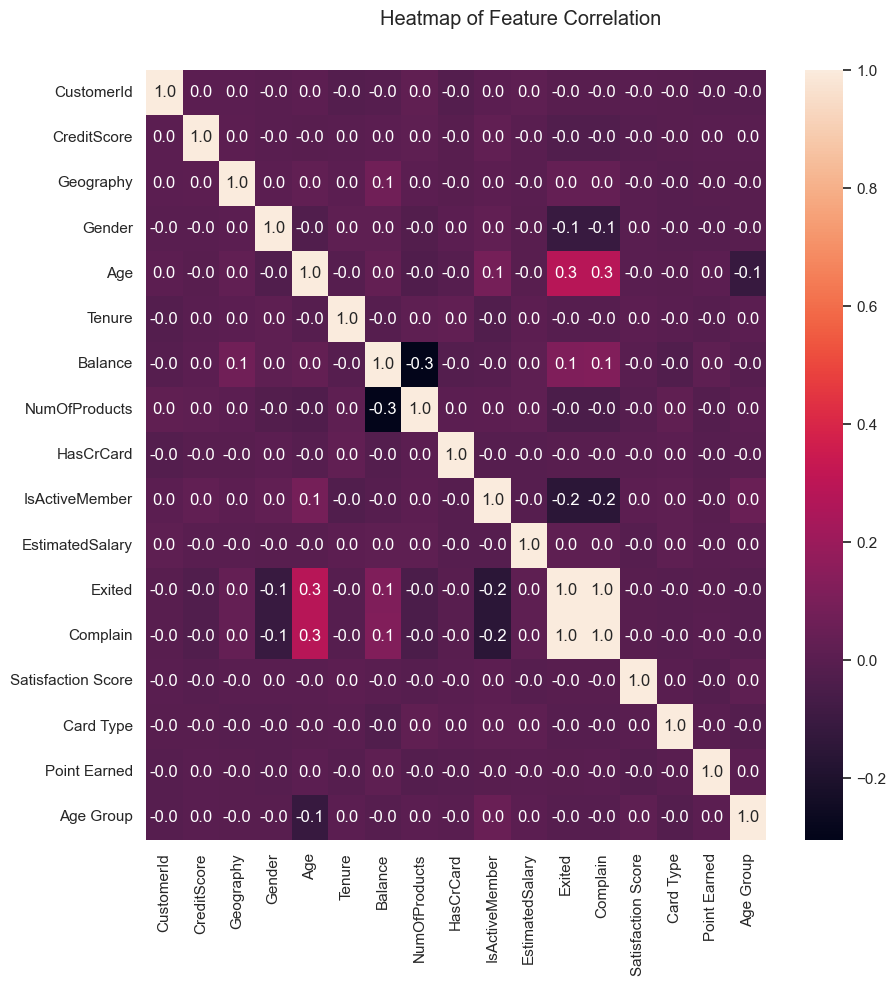

In [44]:
chart = 'Heatmap of Feature Correlation'

plt.figure(figsize=(10, 10))
plt.suptitle(f'{chart}', y=0.94)

# plot a heatmap of feature correlation
sns.heatmap(train.corr(), annot=True, fmt='.1f')
plt.show()

# Heatmap Findings:
>The correlation heatmap suggests a prevalence of non-linear relationships between features and the target variable.

>The graph above shows that there are not many features that are strongly correlated linearly with the target. This means that most of the correlations contained in the dataset are non-linear. Based on this, the appropriate model to use is a model that has good performance on datasets that have many non-linear correlations such as Decision Trees, Gradient Boosting, Neural Networks, and Support Vector Machines (SVM).

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6dl7rfPwvj1_6Kqq7kIVWA.png)
# Business Insights:

1. **Gender Disparity:** Female customers exhibit a higher churn rate (11.4%) compared to males (9%).
2. **Age and Churn:** Customers in the 40-50 age group have the highest churn rate (7.9%), with those in the 30-40 age group closely following.
3. **Geographic Differences:** France and Germany share a higher churn rate (8.1%) than Spain (4.1%).
4. **Activity Matters:** Inactive members demonstrate a significantly higher churn rate (13%) than active members. 
5. **Credit Card Impact:** Customers with credit cards churn at a notably higher rate (14.2%) than those without (6.1%). 
6. **Card Type & Churn:** Diamond cardholders churn more frequently (5.5%) than those with other card types. 
7. **Product Usage Paradox:** Customers owning at least one product churn at a higher rate (14.1%). 
8. **Satisfaction Scores:** No clear correlation is seen between satisfaction scores and churn. 
9. **The Complaint Factor:** All churned customers have a history of complaints. 
10. **Similar Age Distributions:** Churned and retained customers both concentrate in the 30-50 age range with retained customers slightly skewing younger (30-40). 
11. **Credit Score Similarity:** Churned and retained customers show comparable credit score distributions. 
12. **Balance Differences:** Churned customers' balances are concentrated lower (40,000 - 125,000) compared to retained customers. customers. 
## Thanksucts and churn).